# Part 1: Building a Recommendation System for Explicit Feedback Datasets

We will be using a [MovieLens](https://movielens.org/) dataset to build a simple recommendation system in Python. MovieLens is a platform where users rate movies, and get personalized recommendations based on their preferences. It has several publicly available datasets that are widely used for recommendation system tutorials.

MovieLens is an **explicit feedback** dataset. Ratings represent a user's direct feedback towards a movie. An example of implicit feedback would be duration of time a user has spent watching a movie.

## Dependencies

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Dataset

Let's download a small version of the MovieLens dataset. See [here](https://grouplens.org/datasets/movielens/) for zip file url. We're working with data in `ml-latest-small.zip` and will need to add the following files to our repository: 
- ratings.csv
- movies.csv

We can use pandas' `read_csv` method which reads csv files into a pandas dataframe. For the code below to work, move the appropriate csv files into a directory called `data/`.

In [3]:
ratings = pd.read_csv(os.path.join("data", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Exploratory Data Analysis

Let's take a look at the data and perform some basic exploratory data analysis.

In [4]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print("Number of ratings:", n_ratings)
print("Number of unique movieId's:", n_movies)
print("Number of unique users:", n_users)
print("Average number of ratings per user:", round(n_ratings/n_users, 2))
print("Average number of ratings per movie:", round(n_ratings/n_movies, 2))

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


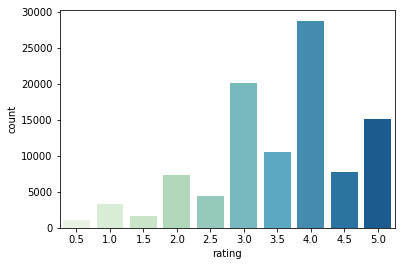

In [5]:
ax = sns.countplot(x="rating", data=ratings, palette="GnBu")
plt.show()

In [6]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count()

Text(0.5,1,'Number of movies rated per user')

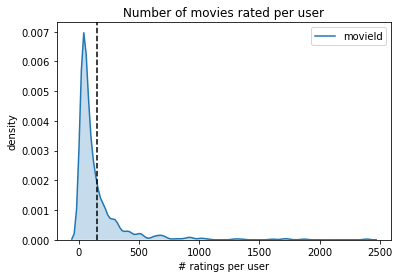

In [7]:
ax = sns.kdeplot(user_freq['movieId'], shade=True)

# add vertical line to represent mean
plt.axvline(user_freq['movieId'].mean(), color="k", linestyle="--")

# add x/y labels and title
ax.set(xlabel='# ratings per user', ylabel='density')
plt.title("Number of movies rated per user")

### Transforming the data

We need to transform our dataframe into a sparse matrix such that rows represents users and columns represent items. This is called a **utility matrix** and forms the basis of collaborative filtering. Remember: collaborative filtering is a technique that identifies similar users and recommends what similar users like. It doesn't require any user or item features! 

<img src="images/user-movie-matrix.png" width="500px" align="left">

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

In [8]:
from sklearn.model_selection import train_test_split

train_ratings, valid_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

In [11]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(N, M))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [94]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)